In [26]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [27]:
DataPath = 'Data'

In [28]:
OuptutPath = 'Output'
os.makedirs(OuptutPath, exist_ok=True)

In [29]:
# Loading all the images from input directory
images = [cv2.imread(os.path.join(DataPath, f)) for f in os.listdir(DataPath) if f.endswith('.jpg')]

In [ ]:
depth_to_print = 3
curvature_threshold = 0.02
Curve_comparison = 4
# find contour of the image up to 4 level hierarchy
for i, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_contour = img

    for j in range(len(contours)):
        level = 0
        parent = hierarchy[0][j][3]
        
        # Traverse up the hierarchy to calculate the depth of the contour
        while parent != -1:
            level += 1
            parent = hierarchy[0][parent][3]
        
        # If contour is deeper than allowed depth, ignore it
        if level > depth_to_print:
            continue
        
        # Approximate the contour to see if it's curved
        epsilon = curvature_threshold * cv2.arcLength(contours[j], True)
        approx = cv2.approxPolyDP(contours[j], epsilon, True)
        
        # Ignore highly curved contours (if the approximation has too many points)
        if len(approx) > Curve_comparison:  
            continue
        
        # Draw the contour if it passes the depth and curvature checks
        cv2.drawContours(img_contour, [contours[j]], -1, (0, 0, 255), 3)

    cv2.imwrite(os.path.join(OuptutPath, f'output_{i}.jpg'), img_contour)

In [ ]:
# Display the images
for i, img in enumerate(images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('Data/1.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to remove noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply binary thresholding
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through the contours and filter based on size or location
for contour in contours:
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)
    
    # Filter based on size or aspect ratio
    if w > 100 and h > 20:  # Example threshold for signature size
        # Crop the signature region
        signature = image[y:y+h, x:x+w]
        
        # Save the extracted signature
        cv2.imwrite(f'Output/signature_{x}_{y}.png', signature)

        # Display the extracted signature (optional)
        cv2.imshow('Signature', signature)
        cv2.waitKey(0)

cv2.destroyAllWindows()


In [ ]:

import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops
import numpy as np

# the parameters are used to remove small size connected pixels outliar 
constant_parameter_1 = 84
constant_parameter_2 = 250
constant_parameter_3 = 100

# the parameter is used to remove big size connected pixels outliar
constant_parameter_4 = 18

# read the input image
img = cv2.imread('Data/1.jpg', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

# connected component analysis by scikit-learn framework
blobs = img > img.mean()
blobs_labels = measure.label(blobs, background=1)
image_label_overlay = label2rgb(blobs_labels, image=img)

fig, ax = plt.subplots(figsize=(10, 6))

# plot the connected components (for debugging)
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()


the_biggest_component = 0
total_area = 0
counter = 0
average = 0.0
for region in regionprops(blobs_labels):
    if (region.area > 10):
        total_area = total_area + region.area
        counter = counter + 1
    # print region.area # (for debugging)
    # take regions with large enough areas
    if (region.area >= 250):
        if (region.area > the_biggest_component):
            the_biggest_component = region.area

average = (total_area/counter)
print("the_biggest_component: " + str(the_biggest_component))
print("average: " + str(average))

# experimental-based ratio calculation, modify it for your cases
# a4_small_size_outliar_constant is used as a threshold value to remove connected outliar connected pixels
# are smaller than a4_small_size_outliar_constant for A4 size scanned documents
a4_small_size_outliar_constant = ((average/constant_parameter_1)*constant_parameter_2)+constant_parameter_3
print("a4_small_size_outliar_constant: " + str(a4_small_size_outliar_constant))

# experimental-based ratio calculation, modify it for your cases
# a4_big_size_outliar_constant is used as a threshold value to remove outliar connected pixels
# are bigger than a4_big_size_outliar_constant for A4 size scanned documents
a4_big_size_outliar_constant = a4_small_size_outliar_constant*constant_parameter_4
print("a4_big_size_outliar_constant: " + str(a4_big_size_outliar_constant))

# remove the connected pixels are smaller than a4_small_size_outliar_constant
pre_version = morphology.remove_small_objects(blobs_labels, a4_small_size_outliar_constant)
# remove the connected pixels are bigger than threshold a4_big_size_outliar_constant 
# to get rid of undesired connected pixels such as table headers and etc.
component_sizes = np.bincount(pre_version.ravel())
too_small = component_sizes > (a4_big_size_outliar_constant)
too_small_mask = too_small[pre_version]
pre_version[too_small_mask] = 0
# save the the pre-version which is the image is labelled with colors
# as considering connected components
plt.imsave('pre_version.png', pre_version)

# read the pre-version
img = cv2.imread('pre_version.png', 0)
# ensure binary
img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# save the the result
cv2.imwrite("output.png", img)

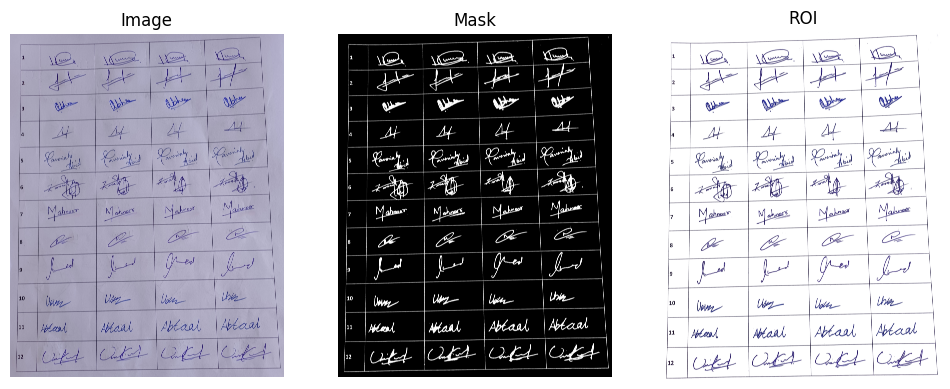

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import supervision as sv

# Load image and HSV color threshold
image = cv2.imread('Data/1.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([90, 38, 0])
upper = np.array([145, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
result = cv2.bitwise_and(image, image, mask=mask)
result[mask==0] = (255, 255, 255)

# Find contours on extracted mask, combine boxes, and extract ROI
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = np.concatenate(cnts)
x,y,w,h = cv2.boundingRect(cnts)
ROI = result[y:y+h, x:x+w]


# Display
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB))
plt.title('ROI')
plt.axis('off')
plt.show()